In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings("ignore")




In [2]:
df=pd.read_csv("weather_cleaned.csv")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


In [4]:
df=pd.read_csv("weather_cleaned.csv")

In [5]:
# Assuming 'df' is your full DataFrame
# Filter data for St. Louis
st_louis_data = df[df['location_city'] == 'St. Louis']

# Ensure the 'time' column is in datetime format
st_louis_data['time'] = pd.to_datetime(st_louis_data['time'])

# Set 'time' as the index for proper time-series operations
st_louis_data.set_index('time', inplace=True)

# Resample to hourly frequency (if necessary)
hourly_data = st_louis_data.select_dtypes(include=[np.number]).resample('H').mean()

# Splitting data into train and test sets (80% train, 20% test)
train_size = int(len(hourly_data) * 0.9)
train = hourly_data.iloc[:train_size]
test = hourly_data.iloc[train_size:]

In [6]:
# Create a mapping between city_idx and location_city
city_mapping = df[['city_idx', 'location_city']].drop_duplicates()

# Display the mapping
print(city_mapping)

# Save the mapping to a CSV file for future reference (optional)
city_mapping.to_csv('city_mapping.csv', index=False)
print("City mapping saved to 'city_mapping.csv'")


KeyError: "['city_idx'] not in index"

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

exog_vars = ['humidity_2m', 'wind_speed_10m', 'soil_temp_0_7cm','dew_point_2m','surface_pressure','precip','soil_temp_0_7cm']  # Replace with your actual columns
train_exog = train[exog_vars]
test_exog = test[exog_vars]


# Define the SARIMA model with the given parameters
model = SARIMAX(
    train['temp_2m'],  # Replace 'temp_2m' with your target column
    order=(1, 1, 0),   # ARIMA(p, d, q)
    seasonal_order=(1, 0, 0, 24),  # SARIMA(P, D, Q, m), where m=24 for daily seasonality
    exog=train_exog,
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
results = model.fit()

# Print model summary
print(results.summary())



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.15246D-01    |proj g|=  2.71171D-01

At iterate    5    f=  5.10105D-01    |proj g|=  8.47606D-02

At iterate   10    f=  5.09884D-01    |proj g|=  2.75962D-02

At iterate   15    f=  5.09873D-01    |proj g|=  1.26993D-02

At iterate   20    f=  5.09869D-01    |proj g|=  7.20547D-03

At iterate   25    f=  5.09869D-01    |proj g|=  9.13327D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     26     68      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


                                     SARIMAX Results                                      
Dep. Variable:                            temp_2m   No. Observations:               195501
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 24)   Log Likelihood              -99679.837
Date:                            Sat, 30 Nov 2024   AIC                         199379.673
Time:                                    21:29:20   BIC                         199481.505
Sample:                                01-01-2000   HQIC                        199409.675
                                     - 04-20-2022                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
humidity_2m         -0.3507      0.000  -1691.632      0.000      -0.351      -0.350
wind_speed_10m   

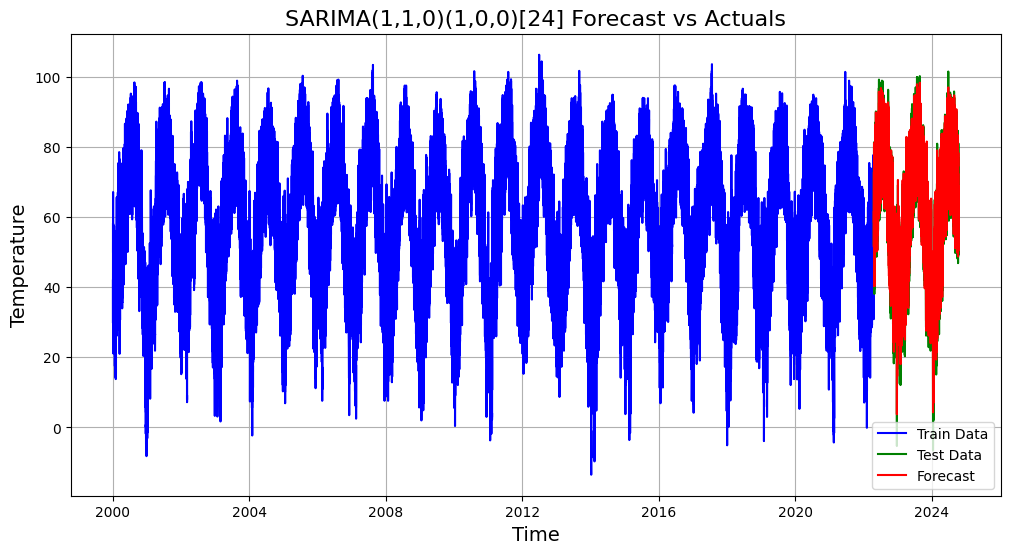

In [9]:
# Forecast the test set
forecast = results.forecast(steps=len(test), exog=test_exog)  # Predict the number of steps in the test set

# Plot the forecast vs actuals
plt.figure(figsize=(12, 6))
plt.plot(train['temp_2m'], label='Train Data', color='blue')
plt.plot(test['temp_2m'], label='Test Data', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('SARIMA(1,1,0)(1,0,0)[24] Forecast vs Actuals', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

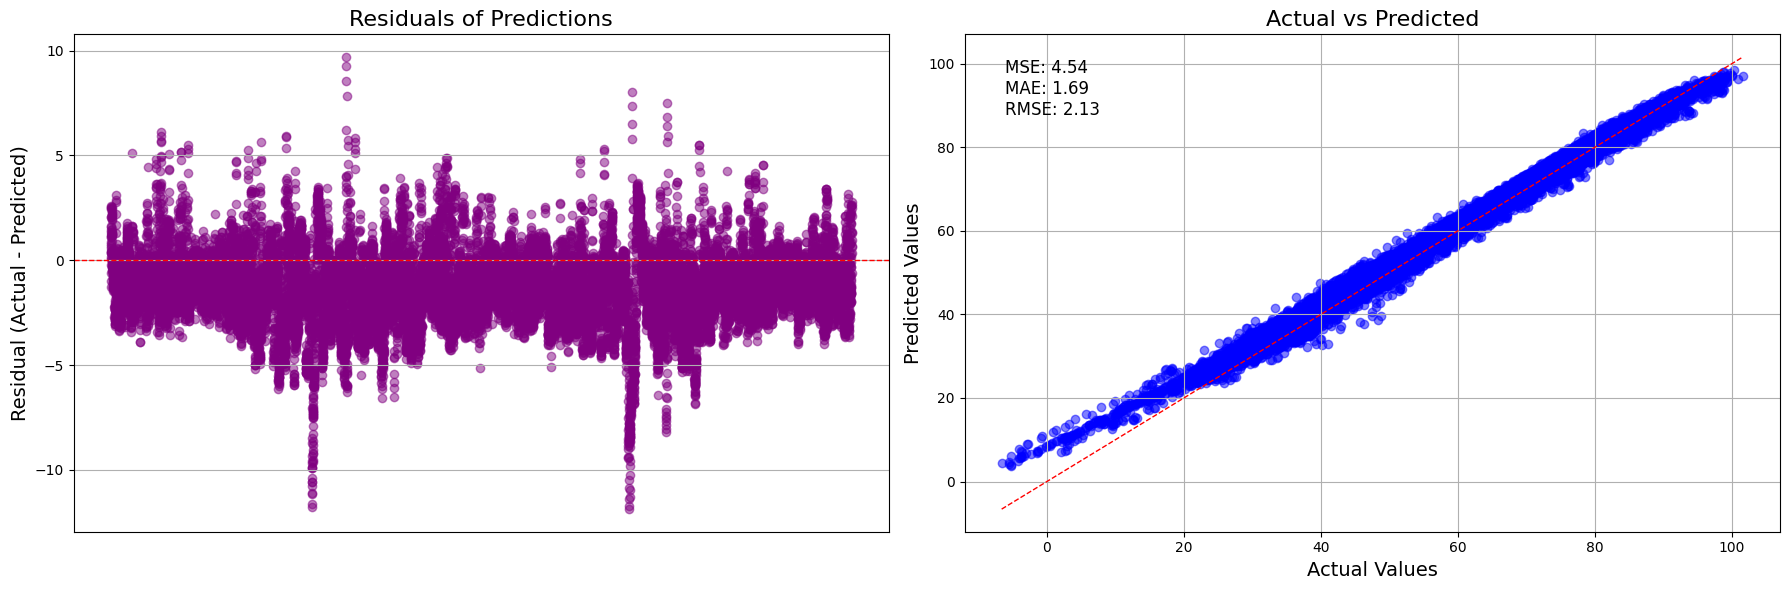

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming 'forecast' contains the predictions and 'test['temp_2m']' contains actuals
# Calculate residuals
residuals = test['temp_2m'] - forecast

# Calculate error metrics
mse = mean_squared_error(test['temp_2m'], forecast)
mae = mean_absolute_error(test['temp_2m'], forecast)
rmse = np.sqrt(mse)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Subplot 1: Residuals
axes[0].scatter(range(len(residuals)), residuals, alpha=0.5, color='purple')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Residuals of Predictions', fontsize=16)
axes[0].set_ylabel('Residual (Actual - Predicted)', fontsize=14)
axes[0].grid(True)
axes[0].set_xticks([])  # Remove x-axis values

# Subplot 2: Actual vs Predicted
axes[1].scatter(test['temp_2m'], forecast, alpha=0.5, color='blue')
axes[1].plot([min(test['temp_2m']), max(test['temp_2m'])], [min(test['temp_2m']), max(test['temp_2m'])],
             color='red', linestyle='--', linewidth=1)  # Perfect prediction line
axes[1].set_title('Actual vs Predicted', fontsize=16)
axes[1].set_xlabel('Actual Values', fontsize=14)
axes[1].set_ylabel('Predicted Values', fontsize=14)
axes[1].grid(True)

# Display error metrics on the plot
text_x = 0.05
text_y = 0.95
axes[1].text(text_x, text_y, f'MSE: {mse:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}',
             transform=axes[1].transAxes, fontsize=12, verticalalignment='top')

# Adjust layout
plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate MSE (Mean Squared Error)
mse = mean_squared_error(test['temp_2m'], forecast)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(test['temp_2m'], forecast)
print(f"Mean Absolute Error (MAE): {mae}")

# Extract AIC and BIC directly from the SARIMA model
aic = results.aic
bic = results.bic

print(f"Akaike Information Criterion (AIC): {aic}")
print(f"Bayesian Information Criterion (BIC): {bic}")

Mean Squared Error (MSE): 4.537083317178958
Root Mean Squared Error (RMSE): 2.130043031766954
Mean Absolute Error (MAE): 1.6866352825284372
Akaike Information Criterion (AIC): 199379.6734469182
Bayesian Information Criterion (BIC): 199481.5053246481


In [26]:
import pickle

# Save the model
results.save('sarima_model.pkl')

print("SARIMA model saved as 'sarima_model.pkl'")

SARIMA model saved as 'sarima_model.pkl'


In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# Load the saved model
results = SARIMAXResults.load('sarima_model.pkl')

print("SARIMA model loaded successfully")


SARIMA model loaded successfully


In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

exog_vars = ['humidity_2m', 'wind_speed_10m', 'soil_temp_0_7cm','dew_point_2m','surface_pressure','precip','soil_temp_0_7cm']  # Replace with your actual columns
train_exog = train[exog_vars]
test_exog = test[exog_vars]
